# Task for Cuetessa, Inc. – Predicting Valence of Pop Songs

## Overview
The aim of this task is to develop a Python-based module to predict the valence of newly released pop songs.  Two approaches are to use as input 1) the audio data (e.g., .wav files) of songs and 2) the lyrics of songs.  Publicly available datasets can be used for training and testing. 


### Data Description (DEAM dataset)

DEAM dataset (DEAM dataset - The MediaEval Database for Emotional Analysis of Music) consists of 1802 excerpts and full songs annotated with valence and arousal values both continuously (per-second) and over the whole song. The metadata describing the audio excerpts (their duration, genre, folksonomy tags).

- Annotations Data: The annotated dataset comes from Soleymani et al. (2013) (http://cvml.unige.ch/databases/emoMusic/). It consists of 45-s clips of 744 songs from the Free Music Archive (https://freemusicarchive.org/) that span a variety of popular genres
    - Annotations are made available in csv format. There are six csv files in this database, four containing
average and standard deviation of arousal and valence continuous annotation for each song.
- Metadata: 
    - including, song title, genre and artist is also provided.
    
    
### Feature Extraction
In this version of the project, the approach of the following research paper will be implemented: [Measuring national mood with music](https://link.springer.com/article/10.3758/s13428-021-01747-7). Specifically, the same [set of features](https://static-content.springer.com/esm/art%3A10.3758%2Fs13428-021-01747-7/MediaObjects/13428_2021_1747_MOESM1_ESM.pdf) will be tried to extract. These features are:
- [x] Spectral Centroid;
- [x] Spectral Rolloff;
- [x] Spectral Contrast — ~~7 bands~~ *(kept the default 6 bands instead)*;
- [x] Mel-Frequency Cepstrum Coefficients (MFCC) — 24 coefficients;
- [x] Zero Crossing Rate;
- [x] Chroma Energy Normalized Statistics (CENS) — 12 chroma;
- [x] Beat Per Minute (BPM);
- [x] Root Mean Square (RMS);

## Initialization

In [1]:
# Initialization 

import pandas as pd
import numpy as np

# statistical visualization
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as librosa
import librosa.display
import IPython.display as ipd

from scipy import stats as st

import os
import re
from tqdm import tqdm


# import module for splitting and cross-validation using gridsearch
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# import machine learning module from the sklearn library
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from imblearn.pipeline import Pipeline, make_pipeline
from tqdm import tqdm
from time import time
from datetime import date



In [2]:
# set up some parameters for plots in this notebook
plt.style.use("seaborn-paper")
sns.set_style("dark", {"axes.facecolor": ".95"})
sns.set_palette("rocket")
sns.set_context("notebook")

plt.rcParams["figure.figsize"] = (10, 4)
%config InlineBackend.figure_format = "retina"



In [3]:
seed = 12345

### Data Preprocessing

In [4]:
# function to determine if columns in file have null values
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")
        
# function to display general information about the dataset
def get_info(df):
    """
    This function uses the head(), info(), describe(), shape() and duplicated() 
    methods to display the general information about the dataset.
    """
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe)
    print()
    print('Columns with nulls:')
    display(get_percent_of_na(df, 4))  # check this out
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")

In [5]:
# 
try:
    annotations = pd.read_csv('/Users/gguillau/Desktop/Practicum/Cuetessa Project/archive/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
    metadata = pd.read_csv('/Users/gguillau/Desktop/Practicum/Cuetessa Project/archive/metadata_1_2000.csv')
except:
    annotations = pd.read_csv("datasets/static_annotations_averaged_songs_1_2000.csv")
    metadata = pd.read_csv('datasets/metadata_1_2000.csv')

print('Data has been read correctly!')




Data has been read correctly!


In [6]:
print('General information about the contract dataset')
get_info(annotations)


General information about the contract dataset
----------------------------------------------------------------------------------------------------
Head:



song_id   valence_mean   valence_std   arousal_mean   arousal_std
0        2            3.1          0.94            3.0          0.63
1        3            3.5          1.75            3.3          1.62
2        4            5.7          1.42            5.5          1.63
3        5            4.4          2.01            5.3          1.85
4        7            5.8          1.47            6.4          1.69

----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.2 KB


None

----------------------------------------------------------------------------------------------------
Describe:



song_id   valence_mean   valence_std   arousal_mean   arousal_std
count  1744.000000    1744.000000   1744.000000    1744.000000   1744.000000
mean   1062.077982       4.903492      1.521950       4.812603      1.466778
std     584.299005       1.173920      0.385496       1.289368      0.367197
min       2.000000       1.600000      0.300000       1.600000      0.460000
25%     536.750000       4.100000      1.270000       3.800000      1.200000
50%    1128.500000       4.900000      1.510000       4.900000      1.480000
75%    1564.250000       5.800000      1.780000       5.800000      1.720000
max    2000.000000       8.400000      2.900000       8.100000      2.590000

----------------------------------------------------------------------------------------------------


<bound method NDFrame.describe of       song_id   valence_mean   valence_std   arousal_mean   arousal_std
0           2            3.1          0.94            3.0          0.63
1           3            3.5          1.75            3.3          1.62
2           4            5.7          1.42            5.5          1.63
3           5            4.4          2.01            5.3          1.85
4           7            5.8          1.47            6.4          1.69
...       ...            ...           ...            ...           ...
1739     1996            3.9          1.87            5.9          2.21
1740     1997            5.3          1.42            3.9          1.14
1741     1998            6.4          1.50            6.2          1.60
1742     1999            4.6          2.11            5.4          1.80
1743     2000            5.8          1.78            6.0          1.67

[1744 rows x 5 columns]>


Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(1744, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



In [7]:
annotations.sample(5)

song_id   valence_mean   valence_std   arousal_mean   arousal_std
439       547            3.4          1.85            4.8          2.09
837      1094            6.4          1.20            6.3          1.27
1175     1432            3.7          1.27            2.6          0.92
237       284            4.4          1.50            5.2          1.17
1504     1761            7.9          0.83            7.1          1.22

In [8]:
# the column names contain empty spaces, fix that
annotations.columns = [col.replace(" ","") for col in annotations.columns]
# drop extra columns
annotations.drop(columns=["valence_std","arousal_std"], inplace=True)
# shortent the column names
annotations.rename(columns={"valence_mean":"valence", "arousal_mean":"arousal"}, inplace=True)
annotations.sample(3)

song_id  valence  arousal
1241     1498      4.8      3.8
1590     1847      3.2      2.6
278       328      5.2      4.2

In [9]:
# show general info
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   song_id                         1744 non-null   int64  
 1   file_name                       744 non-null    object 
 2   Artist                          1744 non-null   object 
 3   Song title                      1744 non-null   object 
 4   start of the segment (min.sec)  1744 non-null   float64
 5   end of the segment (min.sec)    1744 non-null   float64
 6   Genre                           1744 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 95.5+ KB


In [10]:
print('General information about the contract dataset')
get_info(metadata)


General information about the contract dataset
----------------------------------------------------------------------------------------------------
Head:



song_id file_name                          Artist  \
0        2   \t2.mp3  The New Mystikal Troubadours\t   
1        3   \t3.mp3                 Kevin MacLeod\t   
2        4   \t4.mp3                 Kevin MacLeod\t   
3        5   \t5.mp3                 My Bubba & Mi\t   
4        7   \t7.mp3                 Kevin MacLeod\t   

                      Song title  start of the segment (min.sec)  \
0  \tTonight  A Lonely Century\t                            0.48   
1                  \tDD Groove\t                            0.36   
2                  \tSlow Burn\t                            1.29   
3               \tNothing Much\t                            0.36   
4                     \tHustle\t                            0.20   

   end of the segment (min.sec)      Genre  
0                          1.33  \tBlues\t  
1                          1.21  \tBlues\t  
2                          2.14  \tBlues\t  
3                          1.21  \tBlues\t  
4                          1.05  \tBlues\t

----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   song_id                         1744 non-null   int64  
 1   file_name                       744 non-null    object 
 2   Artist                          1744 non-null   object 
 3   Song title                      1744 non-null   object 
 4   start of the segment (min.sec)  1744 non-null   float64
 5   end of the segment (min.sec)    1744 non-null   float64
 6   Genre                           1744 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 95.5+ KB


None

----------------------------------------------------------------------------------------------------
Describe:



song_id  start of the segment (min.sec)  \
count  1744.000000                     1744.000000   
mean   1062.077982                       56.632197   
std     584.299005                       86.436696   
min       2.000000                        0.000000   
25%     536.750000                        1.210000   
50%    1128.500000                       13.484966   
75%    1564.250000                       87.366820   
max    2000.000000                      973.395828   

       end of the segment (min.sec)  
count                   1744.000000  
mean                     135.535407  
std                      152.941069  
min                        0.450000  
25%                        2.080000  
50%                      120.297676  
75%                      228.043515  
max                     1367.472086

----------------------------------------------------------------------------------------------------


<bound method NDFrame.describe of       song_id file_name                          Artist  \
0           2   \t2.mp3  The New Mystikal Troubadours\t   
1           3   \t3.mp3                 Kevin MacLeod\t   
2           4   \t4.mp3                 Kevin MacLeod\t   
3           5   \t5.mp3                 My Bubba & Mi\t   
4           7   \t7.mp3                 Kevin MacLeod\t   
...       ...       ...                             ...   
1739     1996       NaN               The Matt Kurz One   
1740     1997       NaN   Ariel Pink's Haunted Graffiti   
1741     1998       NaN                 Fresh Body Shop   
1742     1999       NaN                    The Gotobeds   
1743     2000       NaN                 Fresh Body Shop   

                         Song title  start of the segment (min.sec)  \
0     \tTonight  A Lonely Century\t                        0.480000   
1                     \tDD Groove\t                        0.360000   
2                     \tSlow Burn\t         


Columns with nulls:
Column file_name has 57.3394% percent of Nulls, and 1000 of nulls
There are 1 columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(1744, 7)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



In [11]:
# print a sample of the meta set
metadata.sample(3)

song_id  file_name                     Artist           Song title  \
1227     1484        NaN  The Dutchess And The Duke                Hands   
222       264  \t264.mp3               Peter Case\t  \tHouse Rent Jump\t   
1279     1536        NaN                  The Years       much much love   

      start of the segment (min.sec)  end of the segment (min.sec)  \
1227                      107.426395                    259.148821   
222                         1.280000                      2.130000   
1279                      101.953900                    180.050045   

            Genre  
1227         Folk  
222   \tCountry\t  
1279      Hip-Hop

In [12]:
# tidy up the column names
metadata.columns = ["song_id","file_name","artist","song_title","segment_start","segment_end", "genre"]
# fill in missing song titles
metadata["song_title"].fillna("unknown", inplace=True)

In [13]:
import re

# remove artifacts
for col in ["artist","song_title","genre"]:
    metadata[col] = [re.sub(r"\t", "", string) for string in metadata[col]]

# constract new file_name column
metadata["file_name"] = metadata["song_id"].astype(str) + ".mp3"

# print sample to check
metadata.sample(3)

song_id file_name                               artist  \
156       188   188.mp3                        Lee Maddeford   
1450     1707  1707.mp3  Sandro Marinoni & Stefano Roncarolo   
749      1006  1006.mp3             Wildbirds and Peacedrums   

                                       song_title  segment_start  segment_end  \
156   Tom's Lullaby (with Les Gauchers Orchestra)       1.210000     2.060000   
1450                                     The Crow      17.440612    75.101497   
749                                    The Window      73.893673   208.654127   

             genre  
156      Classical  
1450          Jazz  
749   Blues-SoulRB

In [14]:
# Merge datasets
df = annotations.merge(metadata, on="song_id",how="outer")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 1743
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1   valence        1744 non-null   float64
 2   arousal        1744 non-null   float64
 3   file_name      1744 non-null   object 
 4   artist         1744 non-null   object 
 5   song_title     1744 non-null   object 
 6   segment_start  1744 non-null   float64
 7   segment_end    1744 non-null   float64
 8   genre          1744 non-null   object 
dtypes: float64(4), int64(1), object(4)
memory usage: 136.2+ KB


### Exploratory Data Analysis

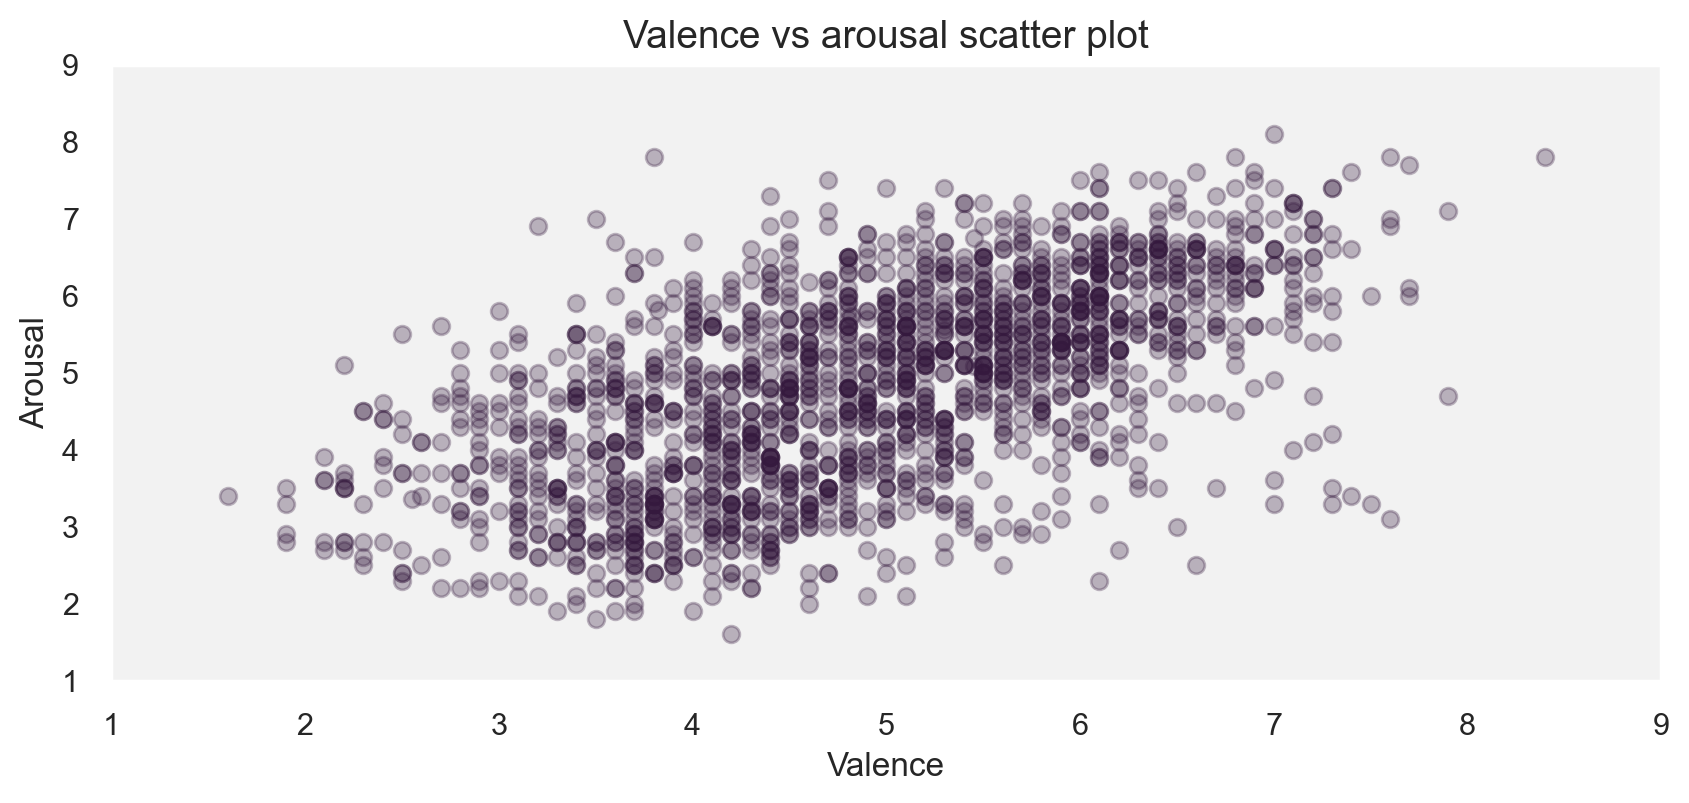

In [15]:
# plot the valence and arousal values distribution
plt.scatter(df["valence"], df["arousal"], alpha=.3)
plt.title("Valence vs arousal scatter plot", fontsize=14)
plt.xlim([1,9])
plt.ylim([1,9])
plt.xlabel("Valence")
plt.ylabel("Arousal");

Unique genres in the dataset:  126



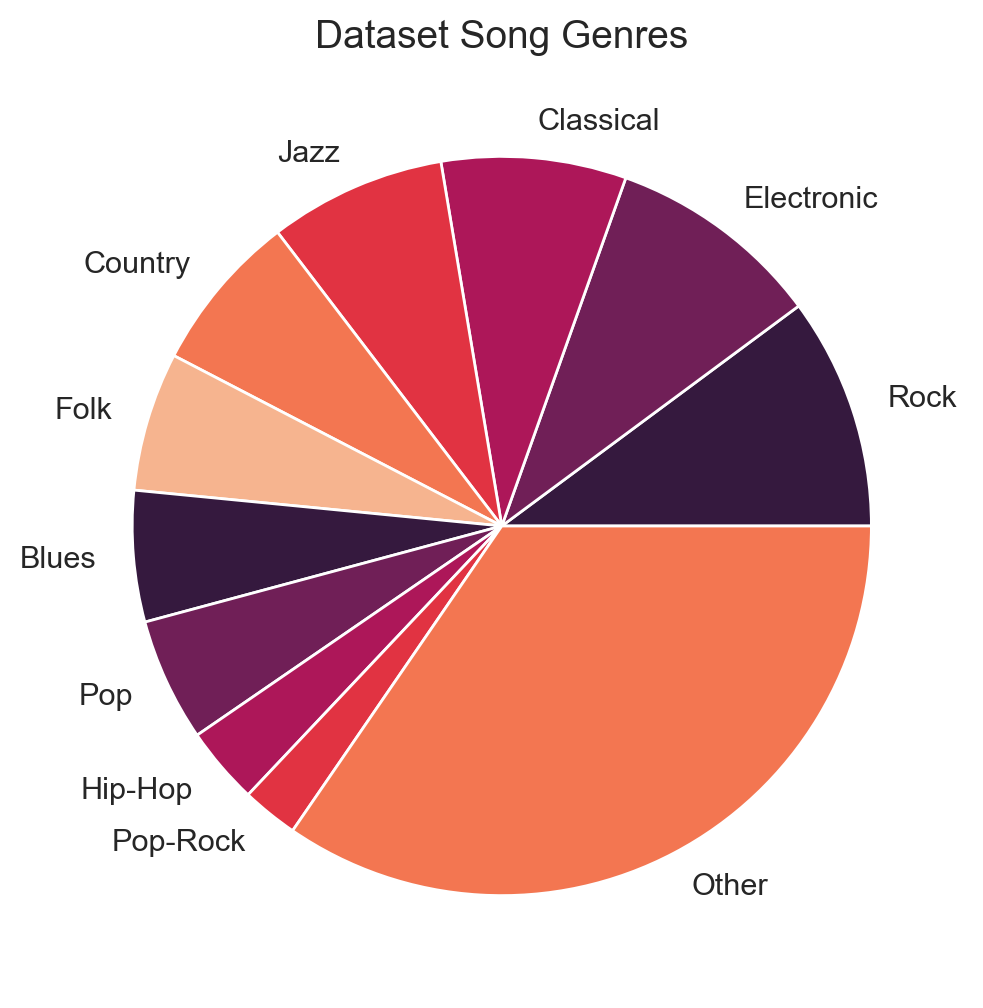

In [16]:
# count the number of genres present in the dataset
nunique_genres = df["genre"].nunique()
print("Unique genres in the dataset:  {}\n".format(nunique_genres))

# select the top 10
top10_genres = df["genre"].value_counts()[:10]
top10_genres.loc["Other"] = df["genre"].value_counts()[10:].sum()

# plot a pie chart with genres ratio
plt.figure(figsize=(6,6))
labels = top10_genres.index
plt.pie(top10_genres, labels=labels)
plt.title("Dataset Song Genres", fontsize=14);

## Audio Features
Investigate the audio features available with the librosa library.



/opt/homebrew/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Sampling rate: 22050
song_id                       1225
valence                        3.4
arousal                        4.6
file_name                 1225.mp3
artist                   Two Prong
song_title                   Earth
segment_start             95.53424
segment_end                 166.76
genre            Country-Folk-Rock
Name: 968, dtype: object


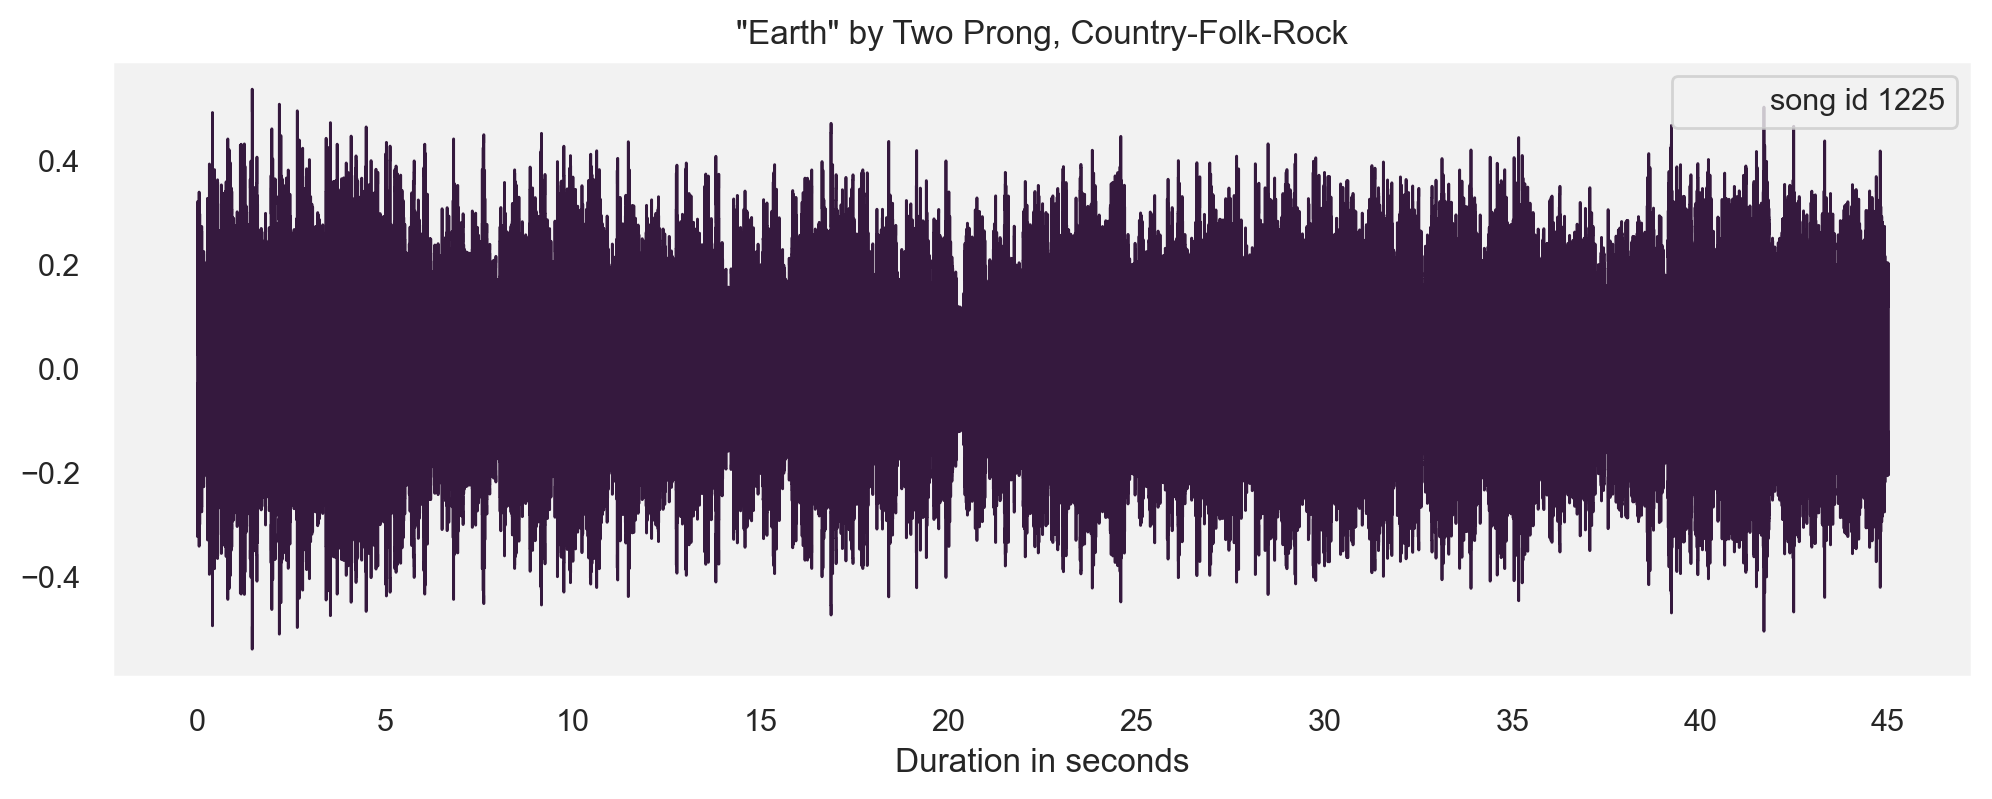

In [17]:
random_idx = np.random.randint(0, 1744)

# select a random song from the dataset
song = df.loc[random_idx, :]

# load the file and print its sampling rate 
file_path = "/Users/gguillau/Desktop/Practicum/Cuetessa Project/archive/DEAM_audio/MEMD_audio/" + song["file_name"]
audio, sample_rate = librosa.load(file_path)
# print info about this song
print(f"Sampling rate: {sample_rate}")
print(song)

# plot the wavefrom
plt.figure(figsize=(12,4))
librosa.display.waveshow(audio, sr=sample_rate) # plot a waveform and play the file
plt.title(f'"{song.song_title[:15]}" by {song.artist}, {song.genre}')
plt.legend([f"song id {song.song_id}"])
plt.xlabel("Duration in seconds")

# output the audio
ipd.Audio(file_path)

### Spectral Centroid

The spectral centroid is a measure of the center of gravity of a sound. This can be used to classify the timbre of a sound, and also to identify different types of sounds. It can be used in applications such as Notion AI, where it can be used to identify particular sounds in a recording.


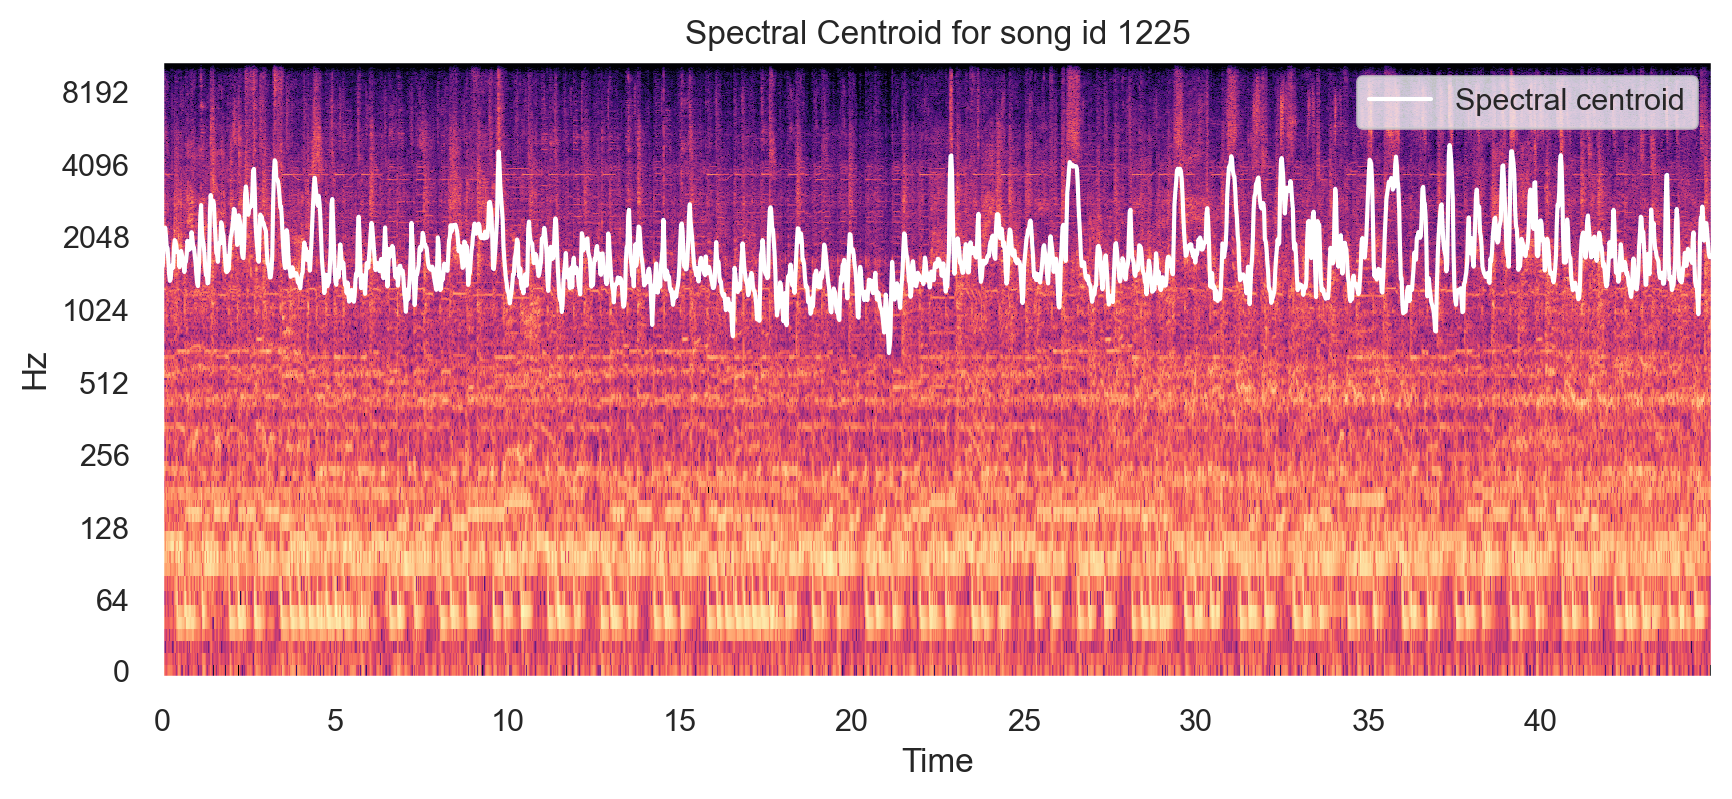

In [18]:
# derive the feature from the audio file
centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)

# obtain other data for plotting
S, phase = librosa.magphase(librosa.stft(y=audio))
times = librosa.times_like(centroid)

fig, ax = plt.subplots()
ax.set(title=f"Spectral Centroid for song id {song.song_id}")

# show spectrogram
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis="log", x_axis="time", ax=ax)
# plot spectral centroid
ax.plot(times, centroid.T, label="Spectral centroid",  color="w")
ax.legend(loc="upper right");


### Spectral Rolloff

Spectral rolloff is a feature of audio signal analysis which measures how quickly the power of a signal decreases as the frequency increases. It can be used to identify the tonal components of a signal and detect the presence of harmonic content.



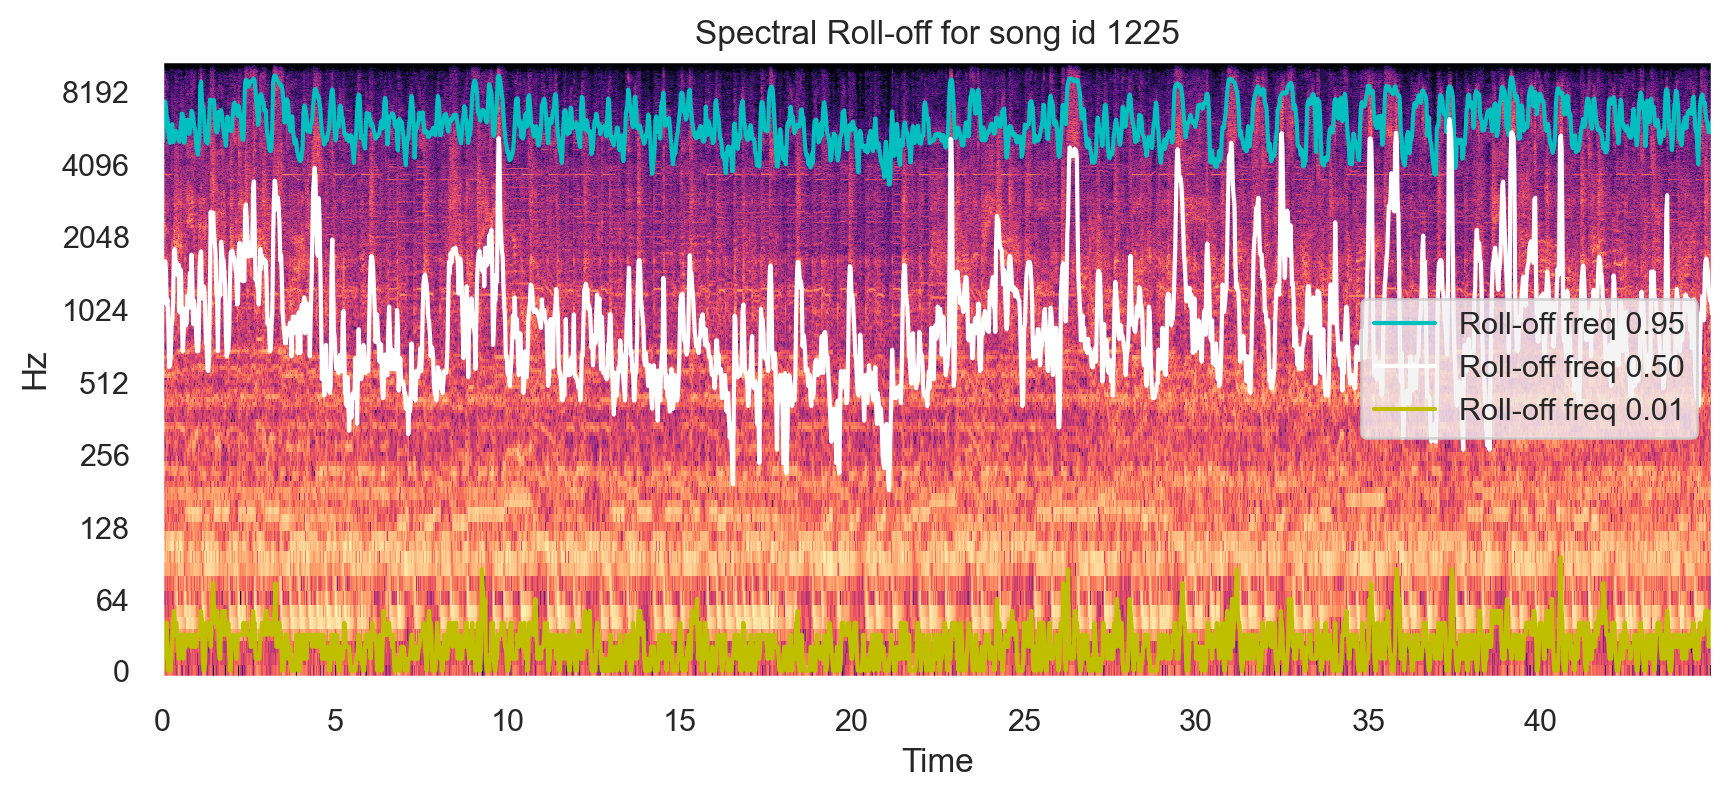

In [19]:
# approximate minimum frequencies with roll_percent=0.95
rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.95)
# approximate minimum frequencies with roll_percent=0.50
rolloff_middle = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.5)
# approximate minimum frequencies with roll_percent=0.01
rolloff_min = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.01)

S, phase = librosa.magphase(librosa.stft(audio))

fig, ax = plt.subplots()
ax.set(title=f"Spectral Roll-off for song id {song.song_id}")

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis="log", x_axis="time", ax=ax)

ax.plot(librosa.times_like(rolloff), rolloff[0], label="Roll-off freq 0.95", color="c")
ax.plot(librosa.times_like(rolloff), rolloff_middle[0], label="Roll-off freq 0.50", color="w")
ax.plot(librosa.times_like(rolloff), rolloff_min[0], label="Roll-off freq 0.01", color="y")
ax.legend(loc='center right');

### Spectral Contrast
Spectral contrast, as implemented in the librosa library, is used to highlight the differences in frequency content of a signal, and can be used to detect and identify individual instruments, as well as providing general information about the signal. The process of spectral contrast works by measuring the overall average energy of each frequency band, then subtracting this average from the original signal. This reveals the differences in the signal which would otherwise be difficult to detect. By doing this, spectral contrast can provide an understanding of the structure of a sound, and can even be used to detect and identify individual instruments.


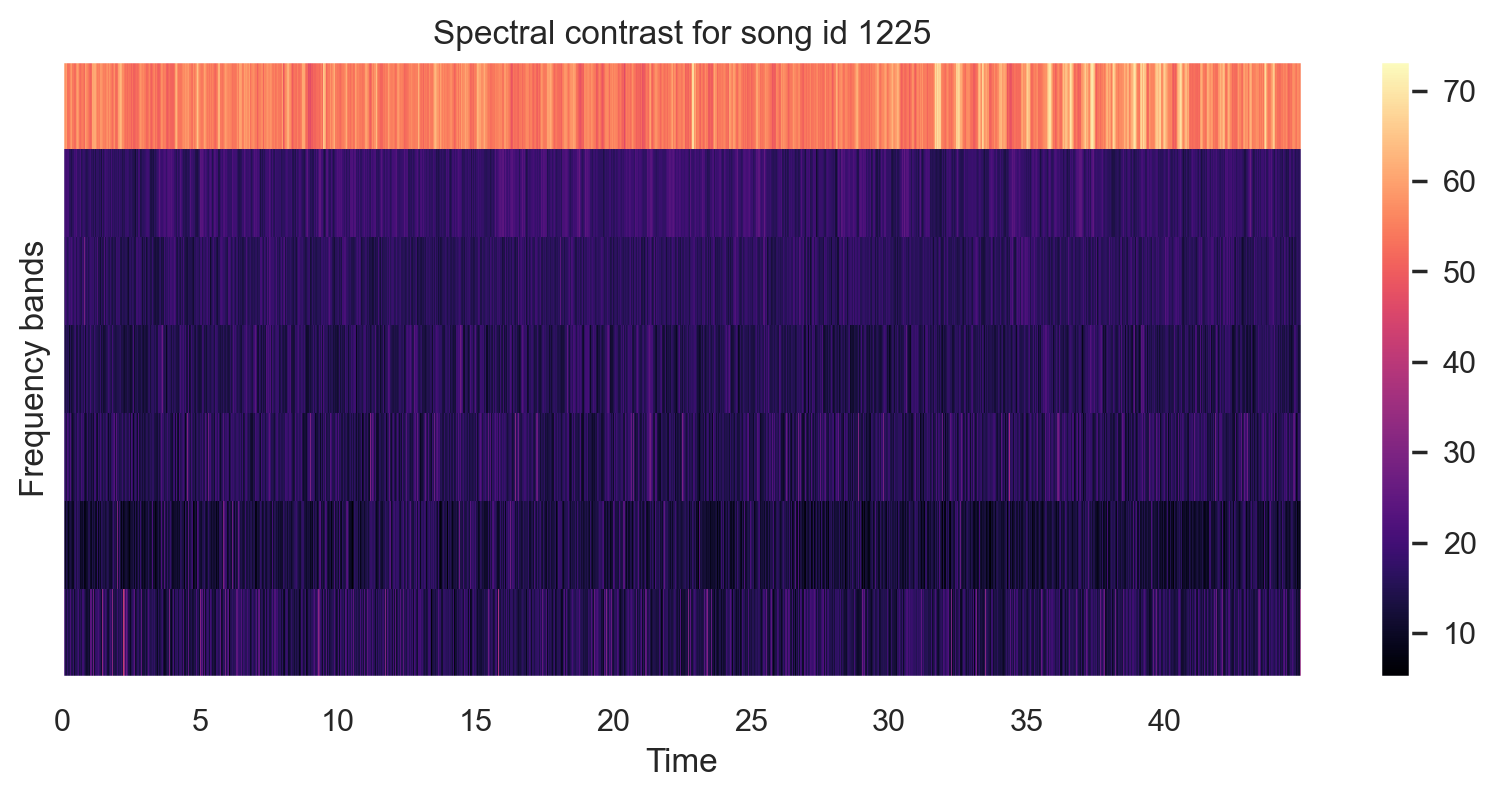

In [20]:
S = np.abs(librosa.stft(y=audio))
contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate, n_bands=6)

fig, ax = plt.subplots()

# plot spectral contrast
img2 = librosa.display.specshow(contrast, x_axis="time", ax=ax)
fig.colorbar(img2, ax=ax)
ax.set(ylabel="Frequency bands", title=f"Spectral contrast for song id {song.song_id}");

### Mel-Frequency Cepstrum Coefficients
MEL-Frequency Cepstrum Coefficients (MFCCs) are a powerful technique for recognizing patterns in audio signals. They are used to represent audio signals in a form that is more easily analyzed by a machine. MFCCs are derived from a Fourier transform of a signal and are used in speech recognition and music recognition applications. MFCCs are also used in audio fingerprinting and speaker recognition.

 

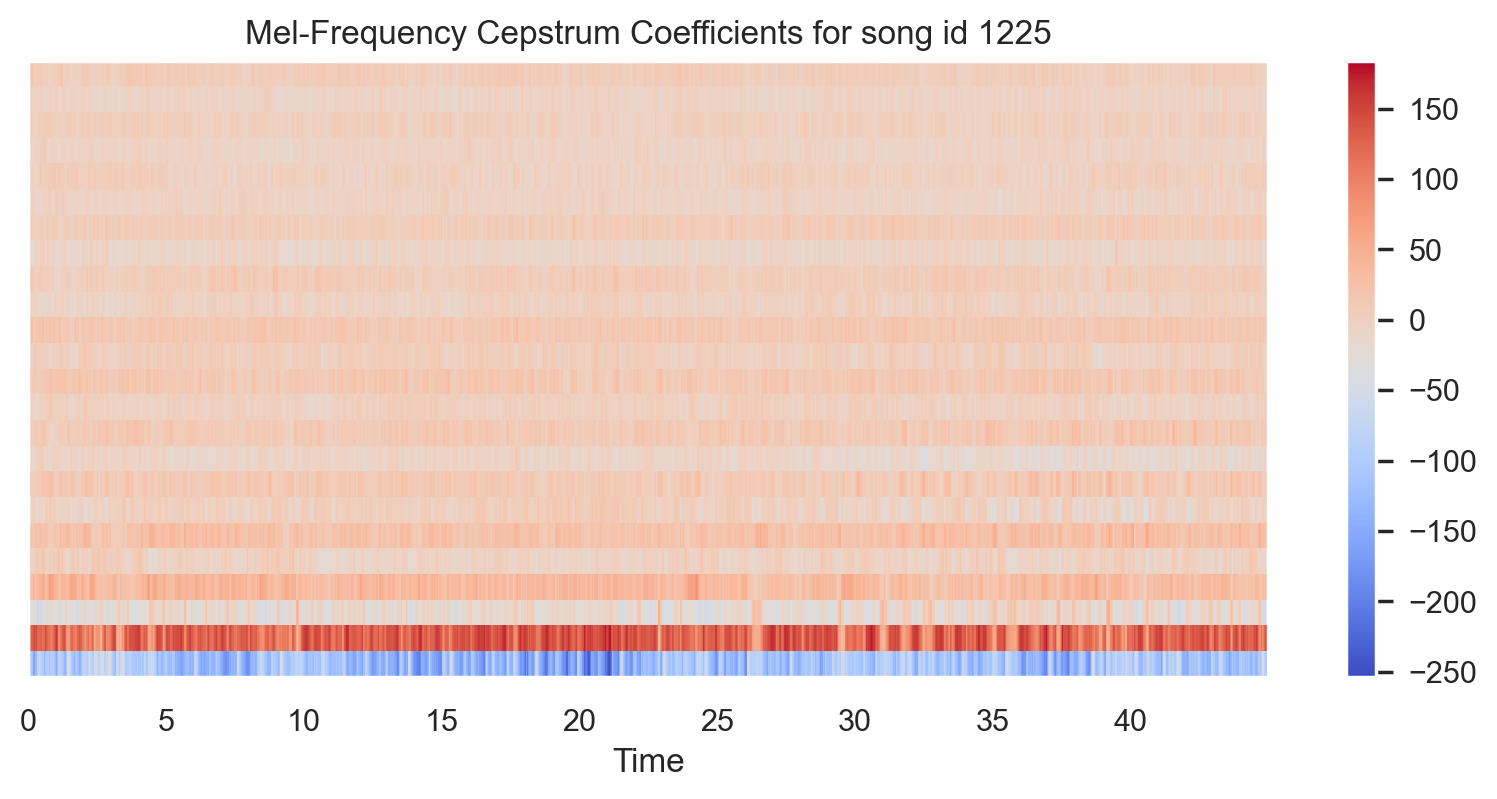

In [21]:
# generate mfccs from the audio file
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=24)

fig, ax = plt.subplots()

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title=f"Mel-Frequency Cepstrum Coefficients for song id {song.song_id}");


### Onset Strength
The onset strength is used to measure the intensity of different sounds in audio files. It is an important measure to consider when analyzing audio signals, as it can help determine the loudness and intensity of a sound in comparison to other sounds. The OS algorithm is also used to identify and differentiate between different types of sounds, making it particularly useful for audio classification.



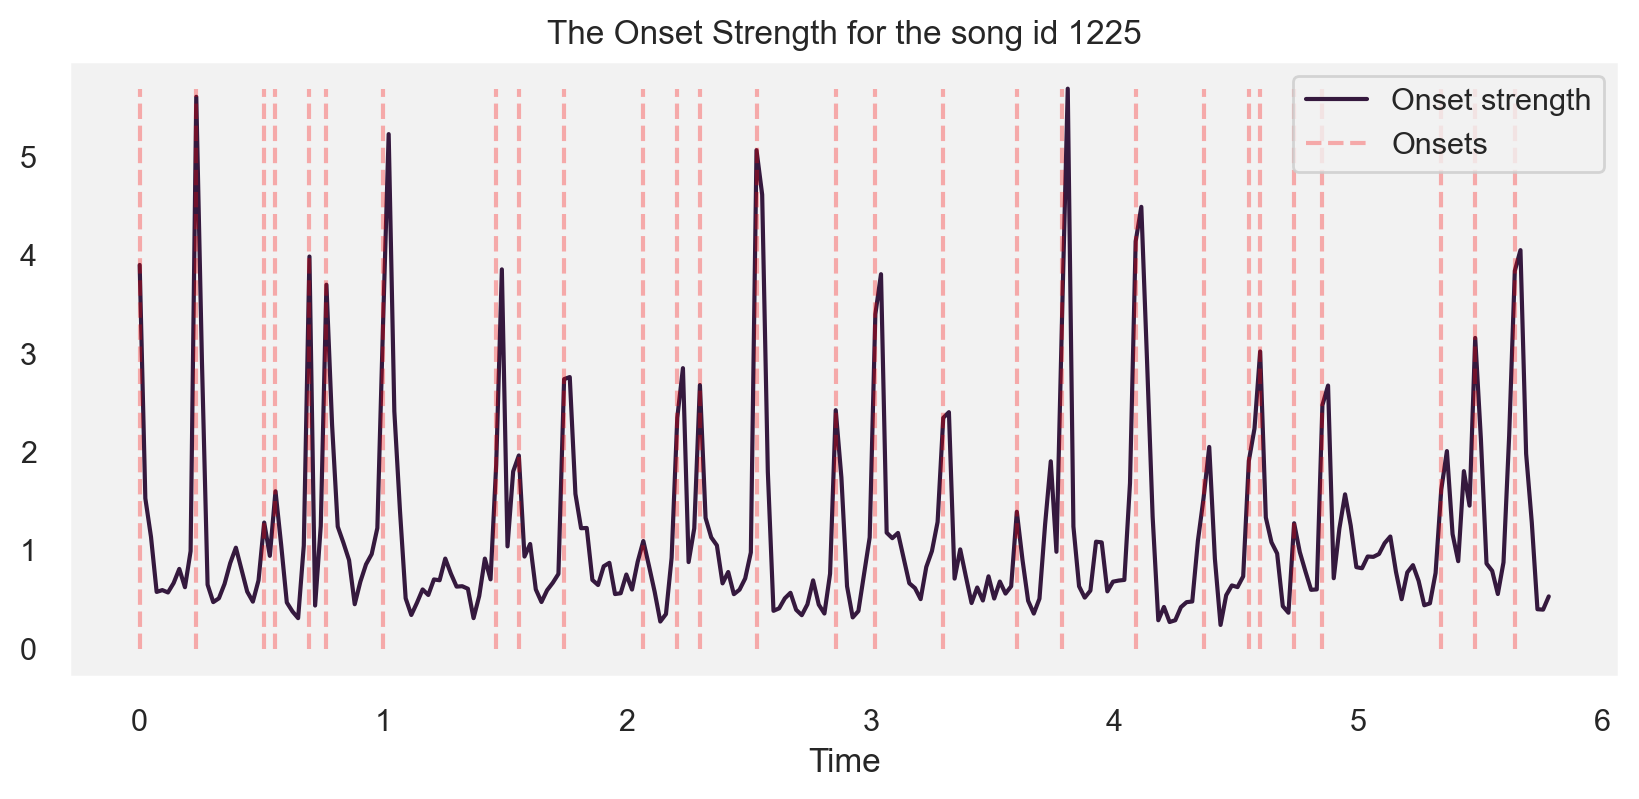

In [22]:
# locate note onset events by picking peaks in an onset strength envelope
# select only a slice for better visualisation
onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)[750:1000]
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sample_rate)
times = librosa.times_like(onset_env, sr=sample_rate)

fig, ax = plt.subplots()
ax.set(title=f"The Onset Strength for the song id {song.song_id}", xlabel="Time")

ax.plot(times, onset_env, label='Onset strength')
ax.vlines(times[onset_frames], 0, onset_env.max(), color='r', alpha=0.3, linestyle='--', label='Onsets')
ax.legend();


### Zero Crossing Rate
The Zero Crossing Rate (ZCR) is a measure used in signal processing to identify the number of times a signal crosses the zero axis. It is often used to analyze audio signals, as it can provide an indication of the perceptual loudness of the audio. ZCR can be calculated by counting the number of times the signal crosses the zero axis in a given time interval.



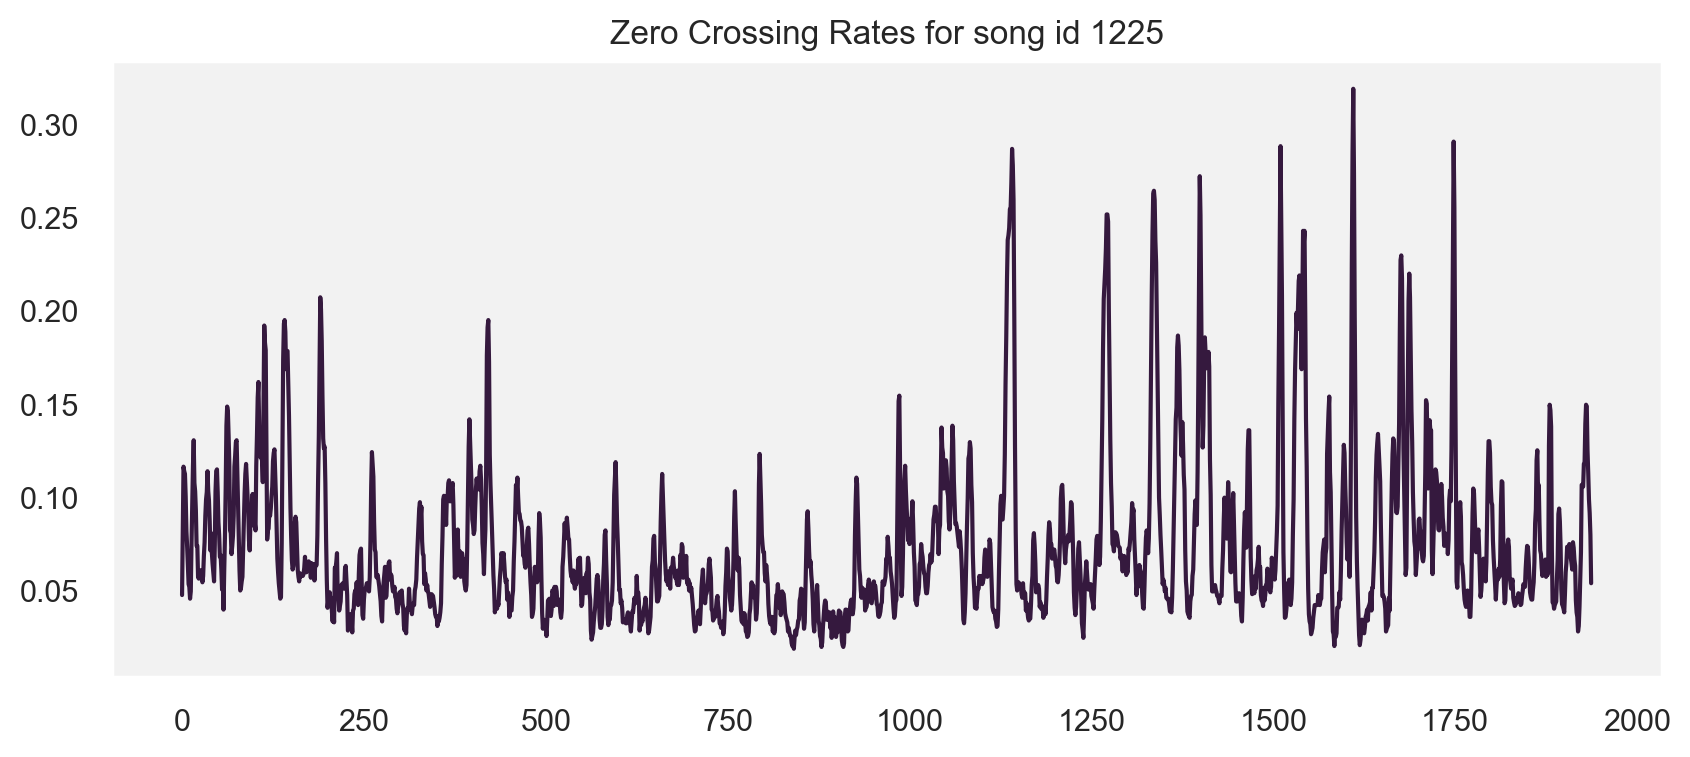

In [23]:
zcrs = librosa.feature.zero_crossing_rate(audio)

plt.plot(zcrs[0])
plt.title(f"Zero Crossing Rates for song id {song.song_id}");


### Chroma Energy Normalized Statistics
CENS is calculated by first computing the chroma vectors for each audio signal. The chroma vector is a 12-dimensional vector composed of the energy in each of the 12 semitones of an octave. The chroma vectors of each signal are then normalized to have unit energy. Finally, the normalized chroma vectors are compared using a similarity measure such as cosine distance.



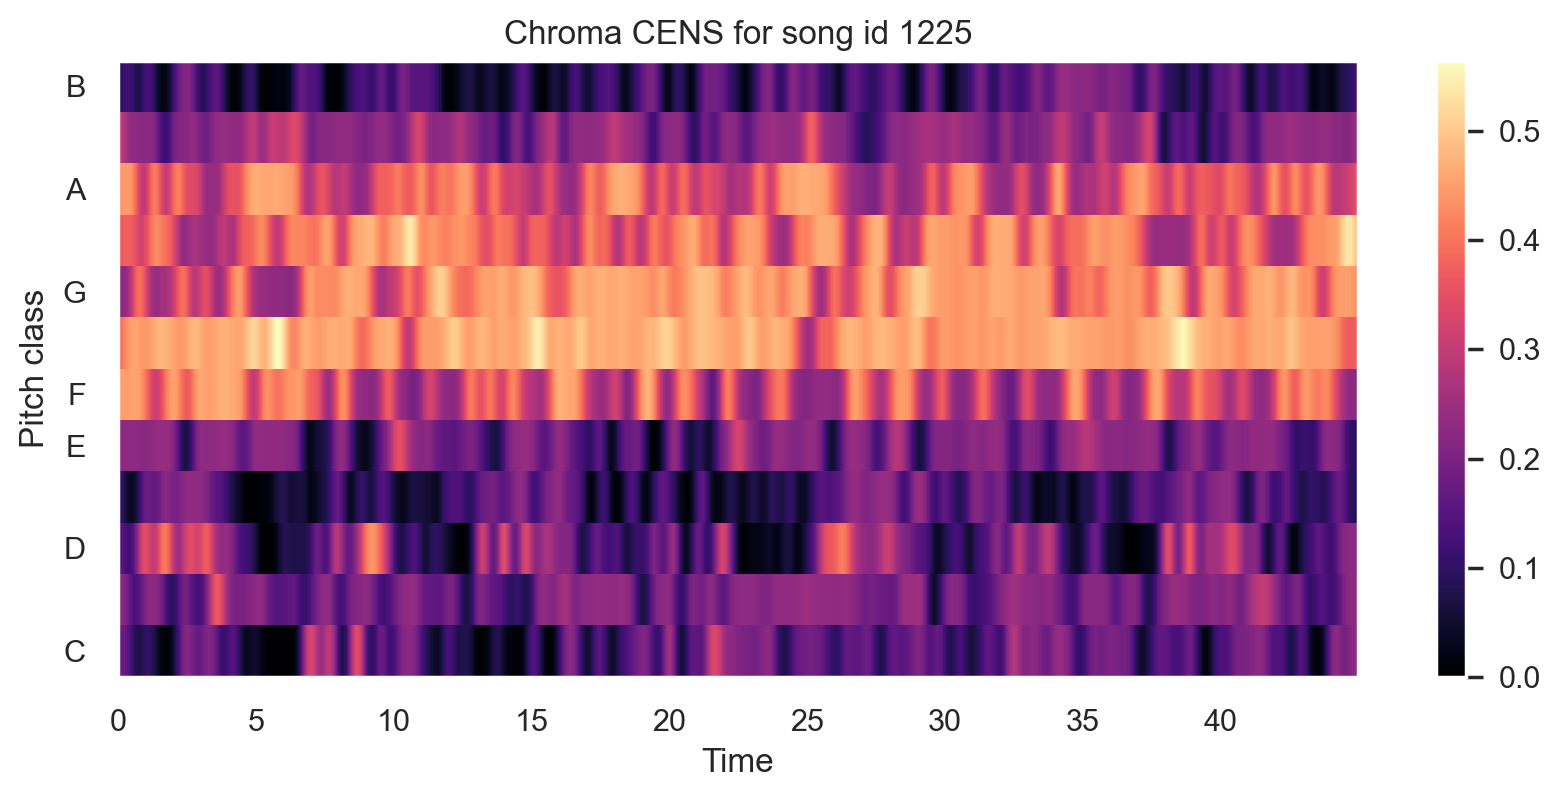

In [24]:
chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sample_rate)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma_cens, y_axis="chroma", x_axis="time")
fig.colorbar(img)
ax.set(title=f"Chroma CENS for song id {song.song_id}");

### Beats Per Minute: Dynamic Tempo
The tempo of a song can be defined as its speed, or how quickly the music moves. It can range from slow and gentle to fast and intense, depending on the genre and style of the music. In a dynamic tempo, the speed of the music changes throughout the song, creating a sense of excitement and anticipation. This can be done by increasing the tempo gradually or by sudden changes in speed.



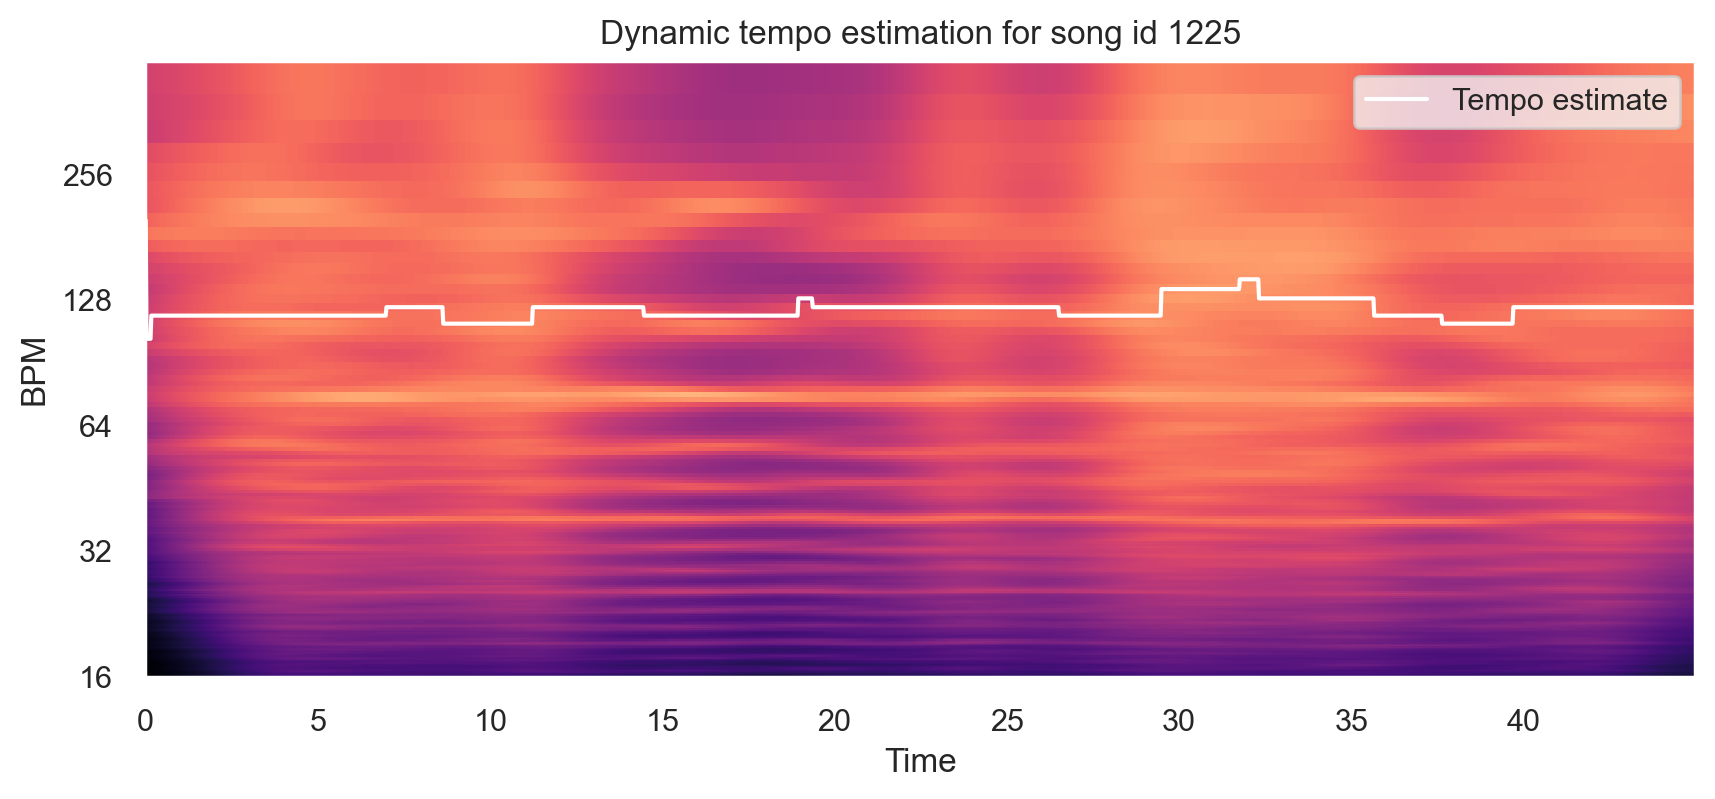

In [25]:
onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate, aggregate=None)

fig, ax = plt.subplots()
tg = librosa.feature.tempogram(onset_envelope=onset_env, sr=sample_rate, hop_length=512)
librosa.display.specshow(tg, x_axis="time", y_axis="tempo", cmap="magma", ax=ax)

ax.plot(librosa.times_like(dtempo), dtempo, color="w", linewidth=1.5, label="Tempo estimate")

ax.set(title=f"Dynamic tempo estimation for song id {song.song_id}")
ax.legend();

### Root Mean Square
RMS is a measure of the average power of a signal over time. It is useful for comparing the loudness of different audio signals, as well as for analyzing the spectral content of signals.


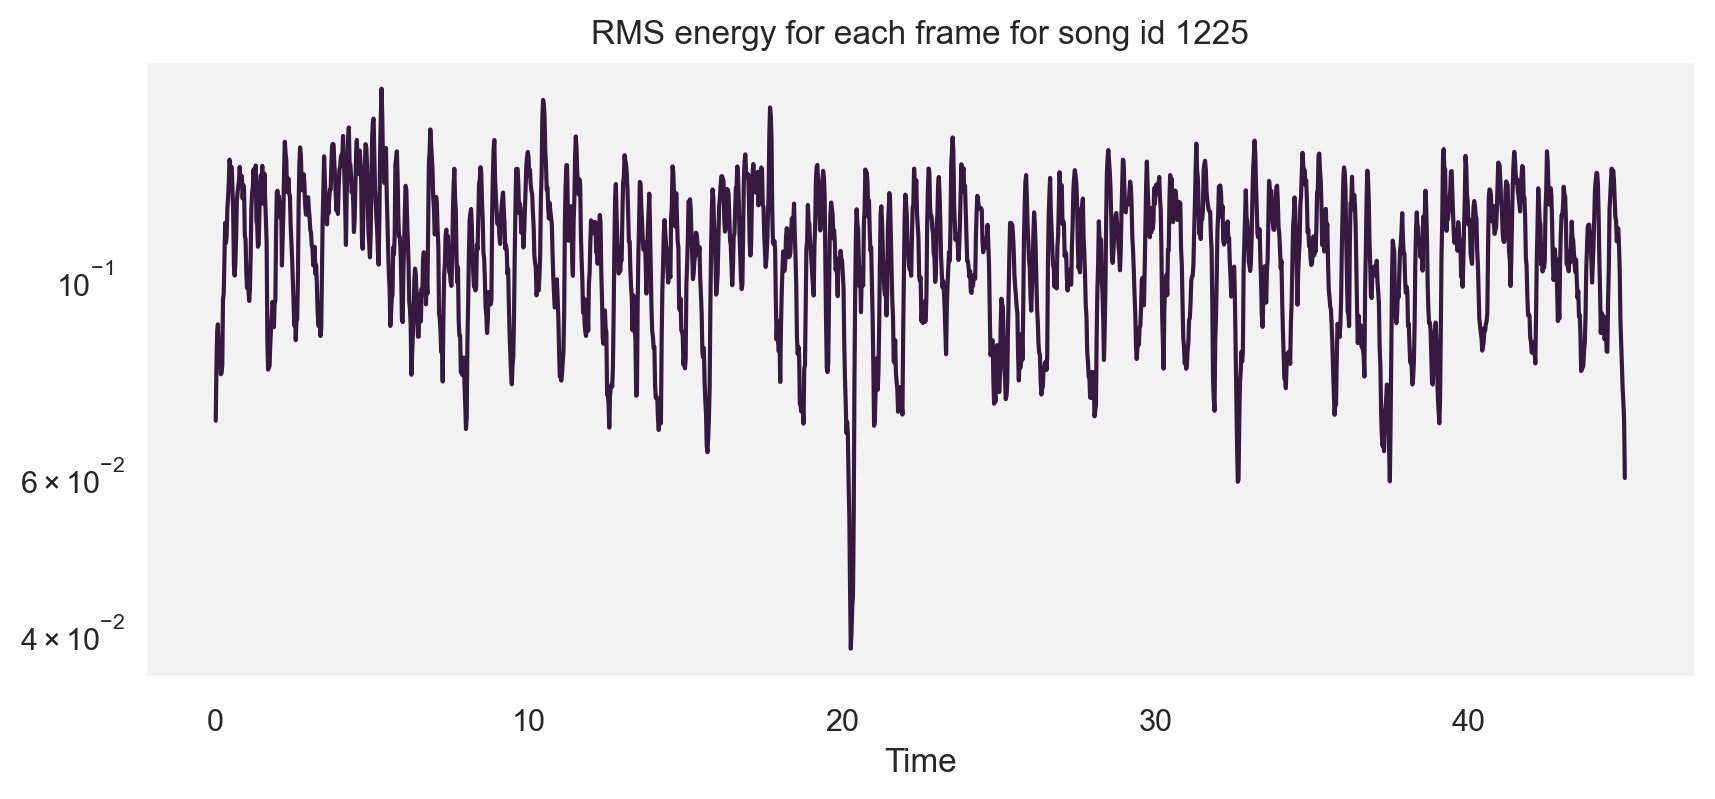

In [26]:

rms = librosa.feature.rms(y=audio)[0]

fig, ax = plt.subplots()
times = librosa.times_like(rms)
ax.set(title=f"RMS energy for each frame for song id {song.song_id}", xlabel="Time")
ax.semilogy(times, rms, label='RMS Energy');

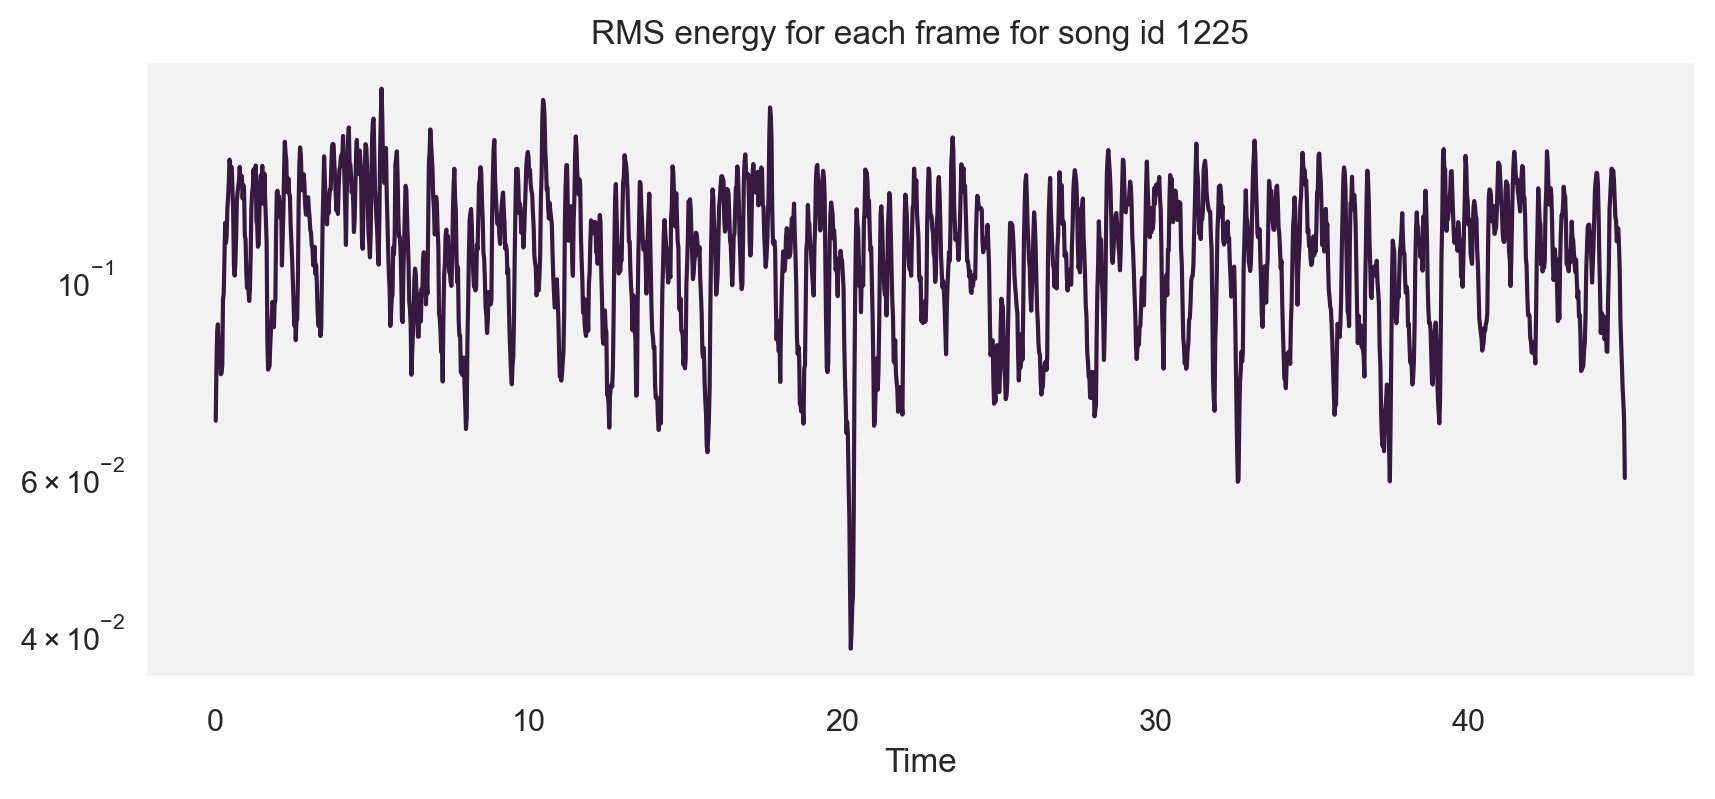

In [27]:
rms = librosa.feature.rms(y=audio)[0]

fig, ax = plt.subplots()
times = librosa.times_like(rms)
ax.set(title=f"RMS energy for each frame for song id {song.song_id}", xlabel="Time")
ax.semilogy(times, rms, label='RMS Energy');

In [28]:
# import essentia

### MACHINE LEARNING

In [29]:
def get_stats(array):
    """
    Takes an array and gives back its mean, standard deviation, 
    first-order difference mean, and first-order difference 
    standard deviation — in this exact order.
    """
    mean = array.mean()
    var = array.var()
    
    diff_mean = np.diff(array).mean()
    diff_var = np.diff(array).var()
    
    return [mean, var, diff_mean, diff_var]

In [30]:
def extract_features(file_path):
    """
    Takes path to an audio file and returns statistics (mean, standard deviation, 
    first-order difference mean, and first-order difference standard deviation)
    for each output array of the following methods:
    
    - Spectral Centroid (1)
    - Spectral Rolloff (3)
    - Spectral Contrast (7)
    - MFCC (24)
    – Onset Strength (1)
    – Zero Crossing Rate (1)
    – CENS (12)
    – BPM Dynamic (1)
    – RMS (1)
    
      204 values output in total.
      
    """
    features = [] # empty list for storing features
    cnt = 0 # counter for keeping track of features number
    
    # load the audio file 
    audio, sample_rate = librosa.load(file_path)
    
    # Spectral Centroid
    cent = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    features.append(get_stats(cent))
    cnt += 1
    
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.95)
    features.append(get_stats(rolloff))
    cnt += 1
    
    rolloff_middle = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.5)
    features.append(get_stats(rolloff_middle))
    cnt += 1
    
    rolloff_min = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.01)
    features.append(get_stats(rolloff_min))
    cnt += 1
    
    # Spectral Contrast
    S = np.abs(librosa.stft(y=audio))
    contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate)
    for band in contrast:
        features.append(get_stats(band))
        cnt += 1
        
    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=24)
    for mfcc in mfccs:
        features.append(get_stats(mfcc))
        cnt += 1
    
    # Onset strength
    onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
    features.append(get_stats(onset_env))
    cnt += 1
    
    # ZCR
    zcrs = librosa.feature.zero_crossing_rate(audio)
    features.append(get_stats(zcrs))
    cnt += 1
    
    # CENS
    chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sample_rate)
    for chroma in chroma_cens:
        features.append(get_stats(chroma))
        cnt += 1
        
    # BPM
    dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate, aggregate=None)
    features.append(get_stats(dtempo))
    cnt += 1
    
    # RMS
    rms = librosa.feature.rms(y=audio)[0]
    features.append(get_stats(rms))
    cnt += 1
    
    features = np.array(features).reshape(cnt * 4)
    
    return features


In [48]:
features_df = []
for i in tqdm(range(len(df))):
    
     file_name = df.loc[i, "file_name"]
     file_path + file_name
     features_df.append(extract_features(file_path))

  0%|                                                  | 0/1744 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
100%|███████████████████████████████████████| 1744/1744 [50:53<00:00,  1.75s/it]


In [50]:
features_df = pd.DataFrame(np.array(features_df))

In [51]:
features_df.to_csv("features_df1.csv")


In [52]:
features_df = pd.read_csv("/Users/gguillau/Desktop/Practicum/Cuetessa Project/features_df1.csv", index_col=0)


In [53]:
# create a featuers amount lookup table
lkp_dict = dict(centroid=1, rolloff_high=1, rolloff_mid=1, rolloff_min=1, 
              contrast=7, mfcc=24, onset=1, zcr=1, cens=12, bpm=1, rms=1)

In [54]:
column_names = []
statistics = ["mean","var","diff_mean","diff_var"]

for feature in lkp_dict:
    for i in range(1, lkp_dict[feature] + 1, 1):
        for statistic in statistics:
            if lkp_dict[feature] != 1:
                column_names.append(feature + "_" + str(i) + "_" + statistic)
            else:
                column_names.append(feature + "_" + statistic)


In [55]:
features_df = pd.DataFrame(np.array(features_df), columns=column_names) 


In [56]:
X = features_df.values
y = df.valence.values

# split the data into the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed)

print(X_train.shape)
print(X_test.shape)

(1395, 204)
(349, 204)


In [57]:
# creata a function for models evaluation
def eval_model(model, X=X_train, y=y_train, show_metrics=1):
    
    # create a pipline to avoid possible target leakage
    pipe = make_pipeline(StandardScaler(), model)
    
    scores = cross_validate(pipe, X, y, cv=5, scoring=("r2", "neg_mean_absolute_error"), n_jobs=-1)
    
    r2 = np.average(scores["test_r2"])
    mae = abs(np.average(scores["test_neg_mean_absolute_error"]))
    fit_time = np.average(scores["fit_time"])
    score_time = np.average(scores["score_time"])
    
    if show_metrics == 1:
        print("Fit time: {:.5f}".format(fit_time))
        print("Score time: {:.5f}".format(score_time))
        print("R2: {:.4f}".format(r2))
        print("MAE {:.4f}".format(mae))
    else:
        return r2, mae

In [58]:
eval_model(SVR())


Fit time: 0.13281
Score time: 0.05344
R2: -0.0024
MAE 0.9597


In [47]:
eval_model(KNeighborsRegressor())

Fit time: 0.01338
Score time: 0.01995
R2: -0.0221
MAE 0.9667


In [42]:
eval_model(LinearRegression())

Fit time: 0.00865
Score time: 0.00071
R2: -0.0035
MAE 0.9605
